In [2]:
# set up matplotlib
%matplotlib widget
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams.update({"font.size": 14})

In [3]:
import numpy as np
import xarray as xr
from scipy.special import j0
from scipy.interpolate import RectBivariateSpline
from xbout import open_boutdataset

In [4]:
case = "2_2" # Case 1 is for anomalous density diffusion only.
filepath = "mms" + str(case) + "/BOUT.dmp.0.nc"
#filepath = "test" + str(case) + "/BOUT.dmp.0.nc"

ds = open_boutdataset(datapath="mms" + str(case) + "/BOUT.dmp.*.nc", chunks={"t": 4})
dsn = xr.open_dataset("circle_lowres.fci.nc")

# Use squeeze() to get rid of the y-dimension, which has length 1 usually unless turbulent.
ds = ds.squeeze(drop=True)
dsn = dsn.squeeze(drop=True)

for key,val in ds.items():
    print(key)

Read in:
<xbout.BoutDataset>
Contains:
<xarray.Dataset> Size: 172MB
Dimensions:             (x: 132, y: 1, z: 132, t: 201)
Coordinates:
    dx                  (x, y, z) float64 139kB dask.array<chunksize=(132, 1, 132), meta=np.ndarray>
    dy                  (x, y, z) float64 139kB dask.array<chunksize=(132, 1, 132), meta=np.ndarray>
    dz                  (x, y, z) float64 139kB dask.array<chunksize=(132, 1, 132), meta=np.ndarray>
  * t                   (t) float64 2kB 0.0 1e+04 2e+04 ... 1.99e+06 2e+06
  * x                   (x) int64 1kB 0 1 2 3 4 5 6 ... 126 127 128 129 130 131
  * y                   (y) float64 8B 0.1963
  * z                   (z) float64 1kB 0.003788 0.01136 ... 0.9886 0.9962
Data variables: (12/52)
    Bxy                 (x, y, z) float64 139kB dask.array<chunksize=(132, 1, 132), meta=np.ndarray>
    G1                  (x, y, z) float64 139kB dask.array<chunksize=(132, 1, 132), meta=np.ndarray>
    G2                  (x, y, z) float64 139kB dask.array<

/home/tirkas1/miniconda3/lib/python3.13/site-packages/xbout/load.py:341: UserWarning: No geometry type found, no physical coordinates will be added
  warn("No geometry type found, no physical coordinates will be added")


In [5]:
dx = ds["dx"].isel(z=0).values

# Get rid of existing "x" coordinate, which is just the index values.
#ds = ds.drop("x")

# Create a new coordinate, which is length in units of rho_s
ds = ds.assign_coords(x=np.arange(ds.sizes["x"])*dx)

#Store just initial values as well.
ds_initial = ds.isel(t=0)

In [ ]:
#For Dirichlet BCs.
dens = ds["Nh+"][:,2:-2,:]
dens_true = dens.copy()

mask = dsn["in_mask"][2:-2,:]
ghost_id = dsn["ghost_id"].values
bdy_pts = dsn["bndry_pts"].values
img_pts = dsn["image_pts"].values
is_plasma = dsn["is_plasma"].values
Rarr = dsn["R"].values[2:-2,:]
Zarr = dsn["Z"].values

spl = RectBivariateSpline(Rarr[:,0], Zarr[0,:], dens.values[100,:,:], kx=1, ky=1)

In [7]:
alpha0 = 2.404825557693792
xc, zc = 1.5, 0.0

x_unit = 0.00022846974366979959 #rho_s0
w_unit = 95788333.030660808    #Omega_ci
t_unit = 1/w_unit

nx = 128
nz = nx + 4
dx = np.float64(1.0) / np.float64(nx)
dz = np.float64(1.0) / np.float64(nz)

# Centers in x; faces/nodes in z if that's your convention
x = (np.arange(nx, dtype=np.float64) + 0.5) * dx     # centered x
z = (np.arange(nz, dtype=np.float64)) * dz           # unshifted z

xhalf  = np.float64(x[len(x)//2])
zhalf  = np.float64(z[len(z)//2])

print(xhalf)

xx, zz = np.meshgrid(x,z,indexing='ij',copy=False)
a      = np.float64(0.333333333333)
D      = np.float64(0.2) #/(x_unit*x_unit*w_unit)
t64 = np.asarray(ds["t_array"].values, dtype=np.float64) # 1D time
t_norm = t64*t_unit
#spatial = ((xx - xhalf)**2 + (zz-zhalf)**2)
spatial = j0(alpha0*np.hypot(xx - xhalf, zz - zhalf)/a)
#temp = 4.0*D*t_norm #t64/t64[-1]
a_norm = a/x_unit
temp = np.exp(-D * (alpha0 / a)**2 * (t_norm))

#dens_true[:,:,:] = np.asarray(spatial)[np.newaxis,:,:] + np.asarray(temp)[:,np.newaxis,np.newaxis]
dens_true[:,:,:] = np.asarray(spatial)[np.newaxis,:,:]*np.asarray(temp)[:,np.newaxis,np.newaxis]

bdy_pts_xz = spl.ev(bdy_pts[:,0], bdy_pts[:,1])
print(np.max(np.abs(bdy_pts_xz)))

0.50390625
0.00022119724319892635


In [8]:
img_pts_xz = spl.ev(img_pts[:,0], img_pts[:,1])

i = 0
for idx in range(nx+4):
    for idz in range(nz):
        gid = int(ghost_id[idx,idz])
        if gid >= 0:
            print(gid)
            if (not (is_plasma[gid,0] and is_plasma[gid,1] and is_plasma[gid,2] and is_plasma[gid,3])):
               print("Contains multiple ghost cell corners.")
            print(img_pts[gid])
            print(img_pts_xz[gid])

0
[ 1.1798759  -0.05776212]
0.029019777405682845
1
[ 1.17744074 -0.05096186]
0.02440155670031159
2
[ 1.17530107 -0.04399834]
0.020378444303748147
3
[ 1.17347038 -0.036777  ]
0.017002560266740536
4
[ 1.17197622 -0.0295726 ]
0.014231521783350997
5
Contains multiple ghost cell corners.
[ 1.17080382 -0.02227157]
0.012127284058451414
6
Contains multiple ghost cell corners.
[ 1.16995945 -0.01489808]
0.010611420004169671
7
Contains multiple ghost cell corners.
[ 1.16944753 -0.00747662]
0.009691633426631822
8
Contains multiple ghost cell corners.
[1.16927083e+00 8.16431199e-17]
0.009372937520625357
9
Contains multiple ghost cell corners.
[1.16944753 0.00747662]
0.009691633426633013
10
Contains multiple ghost cell corners.
[1.16995945 0.01489808]
0.010611420004169841
11
Contains multiple ghost cell corners.
[1.17080382 0.02227157]
0.012127284058450805
12
[1.17197622 0.0295726 ]
0.014231521783351317
13
[1.17347038 0.036777  ]
0.01700256026674111
14
[1.17530107 0.04399834]
0.020378444303747058
15

In [ ]:

dens_diff = np.abs(dens.where(mask) - dens_true.where(mask))


l2_err = np.sqrt(np.nanmean(dens_diff[100,:,:]**2))
l2_unnorm = np.sqrt(np.nansum(dens_diff[100,:,:]**2)*dx*dz)
l2_rel = np.sqrt(np.nansum(dens_diff[100,:,:]**2)*dx*dz) / np.sqrt(np.nansum(dens_true[100,:,:]**2)*dx*dz)
print("L2 (RMS): "    + str(l2_err))
print("L2 (unnorm): " + str(l2_unnorm))
print("L2 (rel): "    + str(l2_rel))

true = dens_true.values[1:10, len(x)//2, len(z)//2] - dens_true.values[0, len(x)//2, len(z)//2]
sim = dens.values[1:10, len(x)//2, len(z)//2] - dens.values[0, len(x)//2, len(z)//2]
#print(*np.abs(sim-true), sep="\n")

init_dens_diff = dens_diff[0,:,:]
mask2 = init_dens_diff.notnull() & (init_dens_diff >= 1e-10)
nerrs = int(mask2.sum().compute())

ii, jj = np.where(mask2)

if nerrs > 0:
    print(init_dens_diff.values[ii[0],jj[0]])
    print(dens.values[0,ii[0],jj[0]])
    print(dens_true.values[0,ii[0],jj[0]])

print(nerrs)


IndexError: Index 400 is out of bounds for axis 0 with size 201

Nh+ data passed has 3 dimensions - will use animatplot.blocks.Pcolormesh()


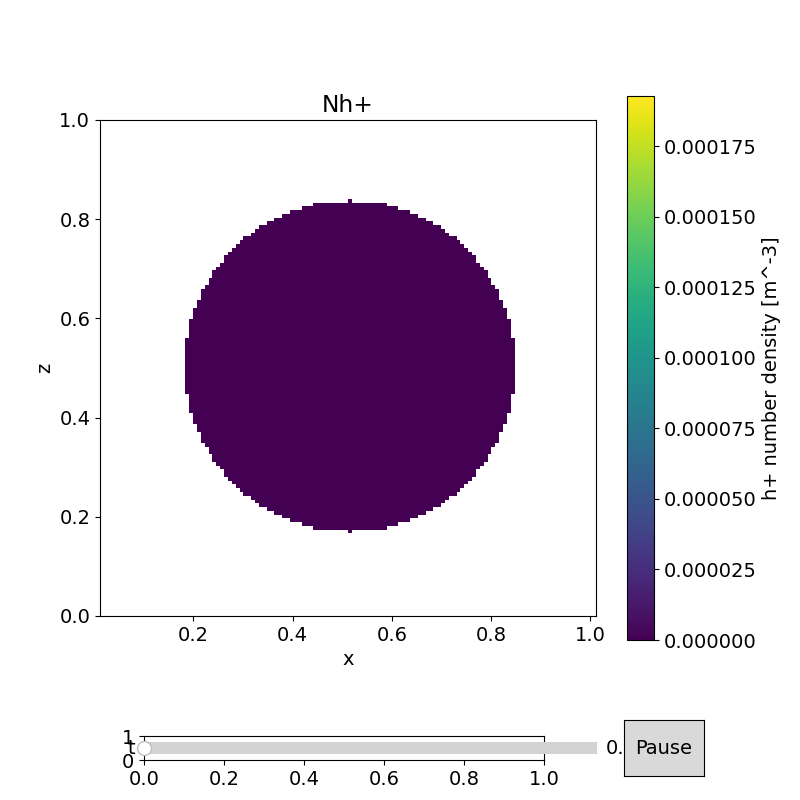

In [ ]:
dens_diff[::10,:,:].bout.animate2D(aspect='equal')

In [ ]:
#For Neumann BCs.
dens = ds["Nh+"]

# Physical coordinates matching dens' interior points
# If your file stores 2D grids:
R = ds["R"]
Z = ds["Z"]

# circle center in physical coords.
rc, zc = 1.5, 0

dx_phys = np.mean(np.diff(np.unique(R[:,0])))     # grid spacing in x
dz_phys = np.mean(np.diff(np.unique(Z[0,:])))     # grid spacing in z

# Cartesian gradients for every time slice
# axis=(1,2) tells np.gradient to differentiate along i,j only (not time)
dndx, dndz = np.gradient(dens, R[:, 0] , Z[0,:], axis=(1,2))

# Radial unit vectors (broadcast over time)
RX = R - rc
RZ = Z - zc
r  = np.hypot(RX, RZ)

nx = np.where(r > 0, RX/r, 0.0)
nz = np.where(r > 0, RZ/r, 0.0)

# Project gradient onto radial direction
dn_dr = dndx*nx + dndz*nz                  # shape (Nt, Ny, Nx)

In [ ]:
dens[:,:,:] = dn_dr[:,:,:]
dens = dens.where(dsn["in_mask"])
#dens = dens.clip(min=0)
dens.bout.animate2D(aspect="equal")